# Interpolate From `MeshArray` To Given Position

Each `MeshArray` contains an array of elementary arrays that (1) are connected at their edges and (2) collectively form a global grid. Overall grid specifications are contained within `gcmgrid` instances, which merely define array sizes and how e.g. grid variables are represented in memory. Importantly, it is only when e.g. grid variables are read from file that sizable memory is allocated.

## Initialize Framework

1. import `MeshArrays` and plotting tools
2. choose e.g. a standard `MITgcm` grid
3. download the grid if needed


In [1]:
using MeshArrays, Plots

pth="../inputs/GRID_LLC90/"
γ=GridSpec("LatLonCap",pth)

http="https://github.com/gaelforget/GRID_LLC90"
!isdir(pth) ? run(`git clone $http $pth`) : nothing;

## Interpolation Code

- get map of tile numbers
- find nearest neighbor


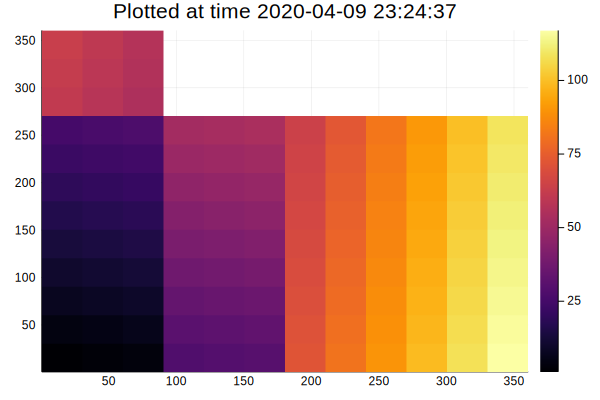

In [2]:
#get map of tile numbers

using MITgcmTools
ni=30; nj=30;
tile=TileMap(γ,ni,nj)
qwckplot(tile)

In [3]:
# find nearest neighbor

using NearestNeighbors

#XC=collect(0.1:0.5:2.1); YC=collect(0.1:0.5:2.1);
XC=0.1; YC=0.1;

Γ=GridLoad(γ)
XC_a=write(Γ["XC"])
YC_a=write(Γ["YC"])
tile_a=write(tile)
kk=findall(isfinite.(XC_a))

x=sin.(pi/2 .-YC_a[kk]*pi/180).*cos.(XC_a[kk]*pi/180);
y=sin.(pi/2 .-YC_a[kk]*pi/180).*sin.(XC_a[kk]*pi/180);
z=cos.(pi/2 .-YC_a[kk]*pi/180);

xx=sin.(pi/2 .-YC*pi/180).*cos.(XC*pi/180);
yy=sin.(pi/2 .-YC*pi/180).*sin.(XC*pi/180);
zz=cos.(pi/2 .-YC*pi/180);

kdtree = KDTree([x y z]')
idxs, dists = knn(kdtree, [xx yy zz]', 4, true)

ik=[idxs[i][1] for i in 1:length(XC)]
[XC_a[ik] YC_a[ik]]

1×2 Array{Float64,2}:
 0.5  0.199365

```
    %1) determine face of current tile ...
    tmp1=1*(map_tile==list_tile(ii));
    tmp11=sum(sum(tmp1,1),2); tmp12=[];
    for ff=1:tmp11.nFaces; tmp12=[tmp12,tmp11{ff}]; end;
    iiFace=find(tmp12);
    %... and its index range within face ...
    tmp1=tmp1{iiFace};
    tmp11=sum(tmp1,2);
    iiMin=min(find(tmp11)); iiMax=max(find(tmp11));
    tmp11=sum(tmp1,1);
    jjMin=min(find(tmp11)); jjMax=max(find(tmp11));
    %... as well as the list of profiles in tile
    ii_prof=find(prof_tile==list_tile(ii));
    %tile corners
    XC11=mygrid.XC{iiFace}(iiMin,jjMin);
    YC11=mygrid.YC{iiFace}(iiMin,jjMin);
    XCNINJ=mygrid.XC{iiFace}(iiMax,jjMax);
    YCNINJ=mygrid.YC{iiFace}(iiMax,jjMax);

    clear tmp*;
```

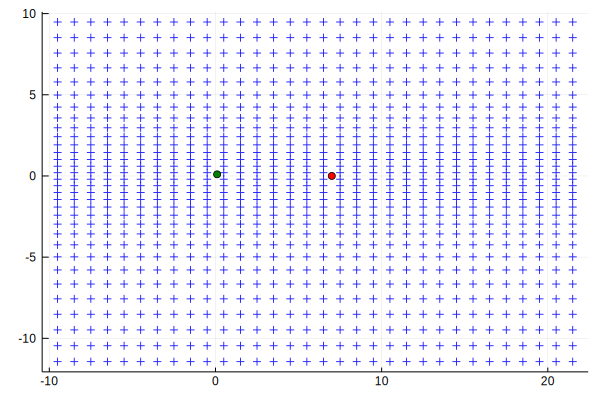

In [4]:
XC_e=exchange(Γ["XC"])
YC_e=exchange(Γ["YC"])

list_tile=[tile_a[ik]]; ii=1;
tmp1=1*(tile.==list_tile[ii])
iiFace=findall(maximum.(tmp1.f).>0)[1]

tmp1=tmp1.f[iiFace]
tmp11=findall(sum(tmp1,dims=2).>0)
iiMin=minimum(tmp11)[1]
iiMax=maximum(tmp11)[1]
tmp11=findall(sum(tmp1,dims=1).>0)
jjMin=minimum(tmp11)[2]
jjMax=maximum(tmp11)[2]

#iiPoints=findall(tmp1.>0)
XC_tmp=view(XC_e.f[iiFace],iiMin-1:iiMax+1,jjMin-1:jjMax+1)
YC_tmp=view(YC_e.f[iiFace],iiMin-1:iiMax+1,jjMin-1:jjMax+1)
XC0=Γ["XG"].f[iiFace][iiMin+Int(ni/2),jjMin+Int(nj/2)]
YC0=Γ["YG"].f[iiFace][iiMin+Int(ni/2),jjMin+Int(nj/2)]

scatter(XC_tmp,YC_tmp,marker=:+,c=:blue,leg=false)
scatter!([XC0],[YC0],c=:red)
scatter!([XC],[YC],c=:green)

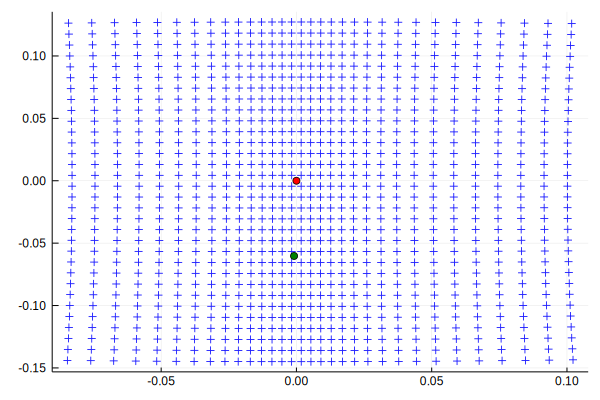

In [5]:
function StereographicProjection(XC0,YC0,XC,YC)
#[xx,yy]=gcmfaces_stereoproj(XC0,YC0,XC,YC);
#object:    compute stereographic projection putting XC0,YC0 at 0,0
#inputs:    XC0,YC0 are the origin longitude,latitude
#           XC,YC are the lon,lat points to project
#outputs:   xx,yy are the projected points
#
#for additional information see :
# http://www4.ncsu.edu/~franzen/public_html/CH795Z/math/lab_frame/lab_frame.html
# http://physics.unm.edu/Courses/Finley/p503/handouts/SphereProjectionFINALwFig.pdf

#compute spherical coordinates:
phi=XC; theta=90 .-YC;
phi0=XC0; theta0=90-YC0;

#compute cartesian coordinates:
X=sind.(theta).*cosd.(phi);
Y=sind.(theta).*sind.(phi);
Z=cosd.(theta);

x=X; y=Y; z=Z;

#bring chosen point to the north pole:
xx=x; yy=y; zz=z;
x=cosd(phi0).*xx+sind(phi0).*yy;
y=-sind(phi0).*xx+cosd(phi0).*yy;
z=zz;

xx=x; yy=y; zz=z;
x=cosd(theta0)*xx-sind(theta0)*zz;
y=yy;
z=sind(theta0)*xx+cosd(theta0)*zz;

#stereographic projection from the south pole:
xx=x./(1 .+z);
yy=y./(1 .+z);

#nrm=sqrt(xx.^2+yy.^2); 
#msk=1+0*nrm; msk(nrm>tan(pi/4/2))=NaN;%mask points outside of pi/4 cone

return xx,yy
end

(xx,yy)=StereographicProjection(XC0,YC0,XC_tmp,YC_tmp)
(prof_x,prof_y)=StereographicProjection(XC0,YC0,XC,YC)

#scatter(xx,yy,c=:blue,leg=false)
scatter(xx,yy,marker=:+,c=:blue,leg=false)
scatter!([0.],[0.],c=:red)
scatter!([prof_x],[prof_y],c=:green)